In [1]:
import sys
import os
sys.path.append("..")

In [2]:
from models.vq_vae import VQ_VAE
from utils.gaze_datasets import GazeDataset
from utils.gaze_datasets import GazeDatasetValid
from utils.gaze_datasets import GazeDatasetTest

In [3]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torch.autograd import Variable
import torch.nn.functional as F 
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline
from matplotlib import pyplot as plt

# Define parameter

In [4]:
import json
json_open = open("../configurations/setting.json", mode='r')
json_load = json.load(json_open)
json_open.close()
num_hiddens = json_load['num_hiddens']
num_residual_hiddens = json_load['num_residual_hiddens']
num_residual_layers = json_load["num_residual_layers"]
embedding_dim = json_load["embedding_dim"]
num_embeddings = json_load["num_embeddings"]
commitment_cost = json_load["commitment_cost"]
decay = json_load["decay"]

In [5]:
num_hiddens = 32
num_residual_hiddens = 32
num_residual_layers = 2

# embedding_dim = 1 #RJS最初
embedding_dim = 8
num_embeddings = 256

commitment_cost = 0.25

decay = 0.99

In [6]:
batch_size = 32
num_training_updates = 100
num_epochs = 500
learning_rate = 1e-3

# Load Dataset

In [7]:
dataset = GazeDataset(transform=transforms.ToTensor())
valid_dataset = GazeDatasetValid(transform=transforms.ToTensor())
test_dataset = GazeDatasetTest(transform=transforms.ToTensor())

In [8]:
train_loader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Train

In [9]:
model = VQ_VAE(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

In [ ]:
%%time
model.train()
train_res_recon_error = []
train_res_perplexity = []
recon_error_s = 0
res_perplexity = 0
data_variance = 1
good_id = 0


optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

f_name = "gaze_vq_vae-256-8dim-2"
name = "gaze_VAE_test/{}.pth".format(f_name)
log_dir = "logs/{}".format(f_name)
if not os.path.isdir(log_dir):
    os.makedirs(log_dir)
writer = SummaryWriter(log_dir=log_dir)


for epoch in range(num_epochs):
    model.train()
    recon_error_s = 0
    res_perplexity = 0
    for data in train_loader:
        data = data.to(device, dtype=torch.float)
        data = data.view(data.size(0), 1, -1)
        optimizer.zero_grad()

        vq_loss, data_recon, perplexity = model(data)
        recon_error = F.mse_loss(data_recon, data) / data_variance        
        loss = recon_error + vq_loss
        
        loss.backward()
        optimizer.step()
        
        recon_error_s += recon_error.item()
        res_perplexity += perplexity.item()
        
#         recon_error_s += recon_error.item()
#         res_perplexity += perplexity.item()
        
#         # マルチGPU用
#         loss = loss.mean()
#         #loss.mean().backward()
#         loss.backward()
#         optimizer.step()
#         perplexity = perplexity.mean()
#         recon_error_s += recon_error.item()
#         res_perplexity += perplexity.item()
    writer.add_scalar("train-loss", recon_error_s/len(train_loader), epoch)
    writer.add_scalar("train-perplexity", res_perplexity/len(train_loader), epoch)
    
    recon_error_s = 0
    res_perplexity = 0
    #検証データで評価
    model.eval()
    with torch.no_grad():
        for data in valid_loader:
            data = data.to(device, dtype=torch.float)
            data = data.view(data.size(0), 1, -1)
            vq_loss, data_recon, perplexity = model(data)
            recon_error = F.mse_loss(data_recon, data) / data_variance
            recon_error_s += recon_error.item()
            res_perplexity += perplexity.item()

    train_res_recon_error.append(recon_error_s/len(valid_loader))
    train_res_perplexity.append(res_perplexity/len(valid_loader))
    writer.add_scalar("valid-loss", recon_error_s/len(valid_loader), epoch)
    writer.add_scalar("valid-perplexity", res_perplexity/len(valid_loader), epoch)
    if recon_error_s/len(train_loader) <= train_res_recon_error[good_id]:
        torch.save(model.state_dict(), name)
        good_id = epoch

    
writer.close()

# 復元

torch.Size([32, 1, 750])


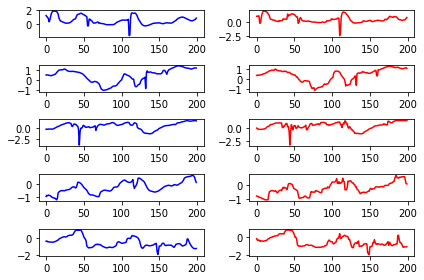

In [9]:
model = VQ_VAE(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)
model.load_state_dict(torch.load('gaze_VAE_test/gaze_vq_vae-256-64dim.pth'))
model.eval()

with torch.no_grad():
    for data in valid_loader:
        data = data.view(data.size(0), 1, -1)
        data = data.float()
        data = data.to(device)
        print(data.shape)
        vq_loss, data_recon, perplexity = model(data)
#         loss = criterion(net.reconstruction(outputs), data)
#         valid_loss += loss.item()
        break
    
axs = []
fig = plt.figure()
for i in range(10):
    ax = fig.add_subplot(5, 2, i+1)
    axs.append(ax)
reco = data_recon
reco = reco.reshape(-1, 750)
t = [i for i in range(200)]
#t = [i for i in range(15000)]
for i in range(5):
    y1 = reco[i].to('cpu').detach().numpy().copy()
    y2 = data[i].to('cpu').detach().numpy().copy()
    y2 = y2.reshape(750)

    axs[i*2].plot(t, y1[:200], color='blue', label='reconstruction')
    axs[i*2+1].plot(t, y2[:200], color='red', label='original')
#     axs[i*2].plot(t, y1, color='blue', label='reconstruction')
#     axs[i*2+1].plot(t, y2, color='red', label='original')
fig.tight_layout()
#plt.savefig('1500.png')
plt.show()

## 復元誤差

In [10]:
model = VQ_VAE(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)
model.load_state_dict(torch.load('gaze_VAE_test/gaze_vq_vae-256-64dim.pth'))
criterion = nn.MSELoss()
model.eval()
valid_loss = 0

with torch.no_grad():
    for data in valid_loader:
        data = data.view(data.size(0), 1, -1)
        data = data.float()
        data = data.to(device)
        vq_loss, data_recon, perplexity = model(data)
        loss = criterion(data_recon, data)
        valid_loss += loss.item()
valid_loss = valid_loss / len(valid_loader)
print(valid_loss)

0.019081902581651065


# 食べ物のデータ処理

In [12]:
model = VQ_VAE(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)
model.load_state_dict(torch.load('gaze_VAE_test/gaze_vq_vae-256-64dim.pth'))
batch_size = 30
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
# net2 = SparseAutoEncoder(1500, 1000).to(device)
# net2.load_state_dict(torch.load('emg1500_1000.pth'))
criterion = nn.MSELoss()

valid_loss = 0

with torch.no_grad():
    for data in test_loader:
        data = data.view(data.size(0), 1, -1)
        data = data.float()
        data = data.to(device)
        z = model._encoder(data)
        print(z.shape)
        z = model._pre_vq_conv(z)
        print(z.shape)
        loss, quantized, perplexity, _ = model._vq_vae(z)
        break

out = quantized.to('cpu').detach().numpy().copy()

torch.Size([30, 32, 374])
torch.Size([30, 64, 374])


## token_idを取り出す

In [13]:
def get_token_id_from_vqvae(model, data):
        bsz = data.shape[0]
        z = model._pre_vq_conv( model._encoder(data) ) 
        loss, quantized, perplexity, vq_vae_encodings = model._vq_vae(z)
        #token_ids = vq_vae_encodings.argmax(1).view(bsz,-1)
        token_ids = vq_vae_encodings.argmax(2).view(bsz,-1)
        return token_ids

In [14]:
id = get_token_id_from_vqvae(model, data)
id = id.to('cpu').detach().numpy().copy()

In [15]:
ls_all = []
for i in range(30):
    ls = []
    for j in range(num_embeddings):
        count = 0
        for k in range(len(id[0])):
            if(id[i][k] == j):
                count += 1
        ls.append(count)
    ls_all.append(ls)

In [16]:
np.save("gaze_VAE_npy/gaze_vq_vae-256-64dim", ls_all)

## 使用されているコーパスの数を調べる

In [17]:
use_flag = [False] * num_embeddings
for i in range(len(id)):
    for j in range(len(id[i])):
        use_flag[id[i][j]] = True

use_flag.count(True)

255

## Decoderへの入力のPCA解析

In [18]:
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
pca = PCA()

out = out.reshape(30, -1)

# 中間層の標準化
ss = preprocessing.StandardScaler()
print(out.shape)
encode = ss.fit_transform(out)

label = [1, 2, 3, 4, 5, 6]
labels = []
for i in label:
    labels.extend([i, i, i, i, i])

pca.fit(encode)
feature = pca.transform(encode)

(30, 23936)


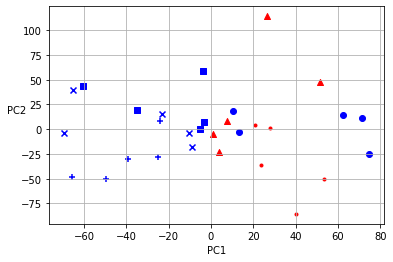

In [19]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()

ax = fig.add_subplot(1,1,1)

label = ['cherry', 'meatball', 'watermelon', 'tomato', 'salted plum', 'wiener']
# ax.scatter(feature[:5,0],feature[:5,1], c='red', marker='.', label='cherry')
# ax.scatter(feature[5:10,0],feature[5:10,1], c='blue',marker='o', label='meatball')
# ax.scatter(feature[10:15,0],feature[10:15,1], c='green',marker='^', label='watermelon')
# ax.scatter(feature[15:20,0],feature[15:20,1], c='yellow',marker='s', label='tomato')
# ax.scatter(feature[20:25,0],feature[20:25,1], c='m',marker='x', label='salted plum')
# ax.scatter(feature[25:,0],feature[25:,1], c='k',marker='+', label='wiener')
ax.scatter(feature[:5,0],feature[:5,1], c='red', marker='.', label='cherry')
ax.scatter(feature[5:10,0],feature[5:10,1], c='blue',marker='o', label='meatball')
ax.scatter(feature[10:15,0],feature[10:15,1], c='red',marker='^', label='watermelon')
ax.scatter(feature[15:20,0],feature[15:20,1], c='blue',marker='s', label='tomato')
ax.scatter(feature[20:25,0],feature[20:25,1], c='blue',marker='x', label='salted plum')
ax.scatter(feature[25:,0],feature[25:,1], c='blue',marker='+', label='wiener')

#ax.set_title('fourth scatter plot')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2', rotation=0)

ax.grid(True)

#ax.legend(loc='upper right')
#lgd=ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
# name = "pdf/emg_vq_vae-{}-{}.pdf".format(num_embeddings, embedding_dim)
# fig.savefig(name, bbox_inch='tight')
fig.show()

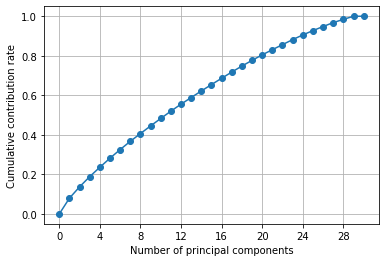

In [24]:
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list( np.cumsum(pca.explained_variance_ratio_)), "-o")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate")
plt.grid()
plt.show()

## コーパスのコサイン類似度

In [ ]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [ ]:
id = get_token_id_from_vqvae(model, data)
id = id.to('cpu').detach().numpy().copy()
corpus = model._vq_vae._embedding.weight
corpus = corpus.to('cpu').detach().numpy().copy()

In [ ]:
cos_sequence = []
all_cos_sequence = []
for i in range(len(id)):
    cos_sequence = []
    for j in range(len(id[i])-1):
        sim = cos_sim(corpus[id[i][j]], corpus[id[i][j+1]])
        cos_sequence.append(sim)
    all_cos_sequence.append(cos_sequence)

In [ ]:
import seaborn as sns

food = ['cherry', 'meat', 'suika', 'tomato', 'ume', 'wiener']
for i in range(len(food)):
    sns.heatmap(all_cos_sequence[i*5:(i+1)*5], cmap= sns.color_palette('coolwarm', 10), vmin = -1, vmax = 1)
    plt.savefig("./fig/test_emg_{}".format(food[i]))
    plt.clf()